In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ResNet50 による 1000種類分類
import torchvision.models as models

from PIL import Image
import torchvision.transforms as transforms
import glob
from sklearn.svm import LinearSVC
import time

In [3]:
resnet50 = models.resnet50(pretrained=True,progress=True)
resnet50 = resnet50.to("cuda:0")
softmax=nn.Softmax(dim=1)

In [ ]:
img = Image.open('animal/cat/458008.jpg')
img = Image.open('animal/dog/415002.jpg')
img = Image.open('animal/horse/197006.jpg')
img = Image.open('animal/lion/105000.jpg')
img = Image.open('animal/tiger/108000.jpg')

In [93]:
# 認識結果の top-5 の結果の表示
SYNSET_FILE='synset_words.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')

In [116]:
image_size = (256, 256) 
occluder = (64,64)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img = Image.open('animal/lion/105000.jpg')
img = image_transform(img)
img = img.unsqueeze(0)

In [117]:
resnet50.eval() 
with torch.no_grad(): 
    out=softmax(resnet50(img.to("cuda:0"))).cpu().numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.99254155 n02129165 lion, king of beasts, Panthera leo
[2] 0.00188663 n02125311 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
[3] 0.00076501 n02130308 cheetah, chetah, Acinonyx jubatus
[4] 0.00049440 n02129604 tiger, Panthera tigris
[5] 0.00028235 n02108551 Tibetan mastiff


In [118]:
heatmap = np.zeros((256, 256))
top_name = synset[top5idx[0]]
print(top_name)
top_st = top5[0]
print(top_st)
for h in range(-56, 247, 8):
    if h <0:
        upper = 0
    else:
        upper = h

    if 256<h+64:
        lower = 256
    else:
        lower = h+64
    
    for w in range(-56, 247, 8):
        mask = torch.zeros_like(img,dtype=torch.bool)
        if w<0:
            left = 0
        else:
            left = w
        
        if 256<w+64:
            right = 256
        else:
            right = w+64
            
        mask[:,:,upper:lower,left:right] = 1
        masked_img = img.clone()
        masked_img[mask]=0
        
        with torch.no_grad():
            out=softmax(resnet50(masked_img.to("cuda:0"))).cpu().numpy()[0]
        
        print("left=",left,", right=",right,", upper=",upper,", lower=",lower,", out=",out[synset.index(top_name)])
        heatmap[upper:lower, left:right] += abs(top_st - out[synset.index(top_name)])

n02129165 lion, king of beasts, Panthera leo
0.99254155
left= 0 , right= 8 , upper= 0 , lower= 8 , out= 0.99221957
left= 0 , right= 16 , upper= 0 , lower= 8 , out= 0.9919642
left= 0 , right= 24 , upper= 0 , lower= 8 , out= 0.99216664
left= 0 , right= 32 , upper= 0 , lower= 8 , out= 0.9919464
left= 0 , right= 40 , upper= 0 , lower= 8 , out= 0.992273
left= 0 , right= 48 , upper= 0 , lower= 8 , out= 0.9918317
left= 0 , right= 56 , upper= 0 , lower= 8 , out= 0.9915592
left= 0 , right= 64 , upper= 0 , lower= 8 , out= 0.99148095
left= 8 , right= 72 , upper= 0 , lower= 8 , out= 0.9918767
left= 16 , right= 80 , upper= 0 , lower= 8 , out= 0.9924982
left= 24 , right= 88 , upper= 0 , lower= 8 , out= 0.9914799
left= 32 , right= 96 , upper= 0 , lower= 8 , out= 0.9910801
left= 40 , right= 104 , upper= 0 , lower= 8 , out= 0.9904316
left= 48 , right= 112 , upper= 0 , lower= 8 , out= 0.9903521
left= 56 , right= 120 , upper= 0 , lower= 8 , out= 0.99041724
left= 64 , right= 128 , upper= 0 , lower= 8 , ou

left= 224 , right= 256 , upper= 0 , lower= 32 , out= 0.9927981
left= 232 , right= 256 , upper= 0 , lower= 32 , out= 0.9928758
left= 240 , right= 256 , upper= 0 , lower= 32 , out= 0.99317414
left= 0 , right= 8 , upper= 0 , lower= 40 , out= 0.9934412
left= 0 , right= 16 , upper= 0 , lower= 40 , out= 0.99416286
left= 0 , right= 24 , upper= 0 , lower= 40 , out= 0.9940707
left= 0 , right= 32 , upper= 0 , lower= 40 , out= 0.9940824
left= 0 , right= 40 , upper= 0 , lower= 40 , out= 0.9941362
left= 0 , right= 48 , upper= 0 , lower= 40 , out= 0.99388254
left= 0 , right= 56 , upper= 0 , lower= 40 , out= 0.99392915
left= 0 , right= 64 , upper= 0 , lower= 40 , out= 0.9933494
left= 8 , right= 72 , upper= 0 , lower= 40 , out= 0.9939324
left= 16 , right= 80 , upper= 0 , lower= 40 , out= 0.9940036
left= 24 , right= 88 , upper= 0 , lower= 40 , out= 0.9939866
left= 32 , right= 96 , upper= 0 , lower= 40 , out= 0.994162
left= 40 , right= 104 , upper= 0 , lower= 40 , out= 0.99358
left= 48 , right= 112 , up

left= 192 , right= 256 , upper= 0 , lower= 64 , out= 0.99459004
left= 200 , right= 256 , upper= 0 , lower= 64 , out= 0.99456835
left= 208 , right= 256 , upper= 0 , lower= 64 , out= 0.9941754
left= 216 , right= 256 , upper= 0 , lower= 64 , out= 0.99351925
left= 224 , right= 256 , upper= 0 , lower= 64 , out= 0.99259406
left= 232 , right= 256 , upper= 0 , lower= 64 , out= 0.9924891
left= 240 , right= 256 , upper= 0 , lower= 64 , out= 0.9926846
left= 0 , right= 8 , upper= 8 , lower= 72 , out= 0.9924926
left= 0 , right= 16 , upper= 8 , lower= 72 , out= 0.99301857
left= 0 , right= 24 , upper= 8 , lower= 72 , out= 0.9943
left= 0 , right= 32 , upper= 8 , lower= 72 , out= 0.99423367
left= 0 , right= 40 , upper= 8 , lower= 72 , out= 0.9943797
left= 0 , right= 48 , upper= 8 , lower= 72 , out= 0.9939904
left= 0 , right= 56 , upper= 8 , lower= 72 , out= 0.9935195
left= 0 , right= 64 , upper= 8 , lower= 72 , out= 0.9937977
left= 8 , right= 72 , upper= 8 , lower= 72 , out= 0.99488914
left= 16 , right

left= 136 , right= 200 , upper= 32 , lower= 96 , out= 0.9939686
left= 144 , right= 208 , upper= 32 , lower= 96 , out= 0.99486345
left= 152 , right= 216 , upper= 32 , lower= 96 , out= 0.9949496
left= 160 , right= 224 , upper= 32 , lower= 96 , out= 0.99666
left= 168 , right= 232 , upper= 32 , lower= 96 , out= 0.9956831
left= 176 , right= 240 , upper= 32 , lower= 96 , out= 0.99575114
left= 184 , right= 248 , upper= 32 , lower= 96 , out= 0.99556977
left= 192 , right= 256 , upper= 32 , lower= 96 , out= 0.99442095
left= 200 , right= 256 , upper= 32 , lower= 96 , out= 0.9936046
left= 208 , right= 256 , upper= 32 , lower= 96 , out= 0.99387485
left= 216 , right= 256 , upper= 32 , lower= 96 , out= 0.9936326
left= 224 , right= 256 , upper= 32 , lower= 96 , out= 0.9929575
left= 232 , right= 256 , upper= 32 , lower= 96 , out= 0.9933427
left= 240 , right= 256 , upper= 32 , lower= 96 , out= 0.99326354
left= 0 , right= 8 , upper= 40 , lower= 104 , out= 0.9923023
left= 0 , right= 16 , upper= 40 , lower

left= 96 , right= 160 , upper= 64 , lower= 128 , out= 0.9676221
left= 104 , right= 168 , upper= 64 , lower= 128 , out= 0.9799355
left= 112 , right= 176 , upper= 64 , lower= 128 , out= 0.98885614
left= 120 , right= 184 , upper= 64 , lower= 128 , out= 0.9917203
left= 128 , right= 192 , upper= 64 , lower= 128 , out= 0.9824979
left= 136 , right= 200 , upper= 64 , lower= 128 , out= 0.99150604
left= 144 , right= 208 , upper= 64 , lower= 128 , out= 0.99196273
left= 152 , right= 216 , upper= 64 , lower= 128 , out= 0.99459064
left= 160 , right= 224 , upper= 64 , lower= 128 , out= 0.99615735
left= 168 , right= 232 , upper= 64 , lower= 128 , out= 0.9972709
left= 176 , right= 240 , upper= 64 , lower= 128 , out= 0.99765956
left= 184 , right= 248 , upper= 64 , lower= 128 , out= 0.99744666
left= 192 , right= 256 , upper= 64 , lower= 128 , out= 0.99637306
left= 200 , right= 256 , upper= 64 , lower= 128 , out= 0.9950943
left= 208 , right= 256 , upper= 64 , lower= 128 , out= 0.9952826
left= 216 , right=

left= 64 , right= 128 , upper= 96 , lower= 160 , out= 0.9445821
left= 72 , right= 136 , upper= 96 , lower= 160 , out= 0.92693144
left= 80 , right= 144 , upper= 96 , lower= 160 , out= 0.6834571
left= 88 , right= 152 , upper= 96 , lower= 160 , out= 0.9162918
left= 96 , right= 160 , upper= 96 , lower= 160 , out= 0.8963308
left= 104 , right= 168 , upper= 96 , lower= 160 , out= 0.93648183
left= 112 , right= 176 , upper= 96 , lower= 160 , out= 0.98375344
left= 120 , right= 184 , upper= 96 , lower= 160 , out= 0.99038506
left= 128 , right= 192 , upper= 96 , lower= 160 , out= 0.99027365
left= 136 , right= 200 , upper= 96 , lower= 160 , out= 0.99383545
left= 144 , right= 208 , upper= 96 , lower= 160 , out= 0.9940487
left= 152 , right= 216 , upper= 96 , lower= 160 , out= 0.99367565
left= 160 , right= 224 , upper= 96 , lower= 160 , out= 0.9928013
left= 168 , right= 232 , upper= 96 , lower= 160 , out= 0.9959403
left= 176 , right= 240 , upper= 96 , lower= 160 , out= 0.99792755
left= 184 , right= 248

left= 184 , right= 248 , upper= 120 , lower= 184 , out= 0.9966456
left= 192 , right= 256 , upper= 120 , lower= 184 , out= 0.9951597
left= 200 , right= 256 , upper= 120 , lower= 184 , out= 0.9946563
left= 208 , right= 256 , upper= 120 , lower= 184 , out= 0.9955771
left= 216 , right= 256 , upper= 120 , lower= 184 , out= 0.9946727
left= 224 , right= 256 , upper= 120 , lower= 184 , out= 0.99406356
left= 232 , right= 256 , upper= 120 , lower= 184 , out= 0.9942683
left= 240 , right= 256 , upper= 120 , lower= 184 , out= 0.99317
left= 0 , right= 8 , upper= 128 , lower= 192 , out= 0.9939521
left= 0 , right= 16 , upper= 128 , lower= 192 , out= 0.99482477
left= 0 , right= 24 , upper= 128 , lower= 192 , out= 0.9951756
left= 0 , right= 32 , upper= 128 , lower= 192 , out= 0.9945616
left= 0 , right= 40 , upper= 128 , lower= 192 , out= 0.9947319
left= 0 , right= 48 , upper= 128 , lower= 192 , out= 0.9947805
left= 0 , right= 56 , upper= 128 , lower= 192 , out= 0.9963534
left= 0 , right= 64 , upper= 128

left= 8 , right= 72 , upper= 152 , lower= 216 , out= 0.9972121
left= 16 , right= 80 , upper= 152 , lower= 216 , out= 0.9965919
left= 24 , right= 88 , upper= 152 , lower= 216 , out= 0.9957137
left= 32 , right= 96 , upper= 152 , lower= 216 , out= 0.994423
left= 40 , right= 104 , upper= 152 , lower= 216 , out= 0.9881287
left= 48 , right= 112 , upper= 152 , lower= 216 , out= 0.9844433
left= 56 , right= 120 , upper= 152 , lower= 216 , out= 0.97574615
left= 64 , right= 128 , upper= 152 , lower= 216 , out= 0.9529015
left= 72 , right= 136 , upper= 152 , lower= 216 , out= 0.9586278
left= 80 , right= 144 , upper= 152 , lower= 216 , out= 0.95202076
left= 88 , right= 152 , upper= 152 , lower= 216 , out= 0.97297716
left= 96 , right= 160 , upper= 152 , lower= 216 , out= 0.92746294
left= 104 , right= 168 , upper= 152 , lower= 216 , out= 0.9340136
left= 112 , right= 176 , upper= 152 , lower= 216 , out= 0.98373693
left= 120 , right= 184 , upper= 152 , lower= 216 , out= 0.9876017
left= 128 , right= 192 

left= 112 , right= 176 , upper= 176 , lower= 240 , out= 0.99113995
left= 120 , right= 184 , upper= 176 , lower= 240 , out= 0.99356174
left= 128 , right= 192 , upper= 176 , lower= 240 , out= 0.9920739
left= 136 , right= 200 , upper= 176 , lower= 240 , out= 0.9904822
left= 144 , right= 208 , upper= 176 , lower= 240 , out= 0.9874046
left= 152 , right= 216 , upper= 176 , lower= 240 , out= 0.98870075
left= 160 , right= 224 , upper= 176 , lower= 240 , out= 0.9885311
left= 168 , right= 232 , upper= 176 , lower= 240 , out= 0.9901929
left= 176 , right= 240 , upper= 176 , lower= 240 , out= 0.99187183
left= 184 , right= 248 , upper= 176 , lower= 240 , out= 0.9941977
left= 192 , right= 256 , upper= 176 , lower= 240 , out= 0.9943758
left= 200 , right= 256 , upper= 176 , lower= 240 , out= 0.9946878
left= 208 , right= 256 , upper= 176 , lower= 240 , out= 0.9954189
left= 216 , right= 256 , upper= 176 , lower= 240 , out= 0.9944583
left= 224 , right= 256 , upper= 176 , lower= 240 , out= 0.9940356
left= 

left= 208 , right= 256 , upper= 200 , lower= 256 , out= 0.9951261
left= 216 , right= 256 , upper= 200 , lower= 256 , out= 0.99486005
left= 224 , right= 256 , upper= 200 , lower= 256 , out= 0.9945768
left= 232 , right= 256 , upper= 200 , lower= 256 , out= 0.994863
left= 240 , right= 256 , upper= 200 , lower= 256 , out= 0.9935795
left= 0 , right= 8 , upper= 208 , lower= 256 , out= 0.9924925
left= 0 , right= 16 , upper= 208 , lower= 256 , out= 0.9934243
left= 0 , right= 24 , upper= 208 , lower= 256 , out= 0.99268323
left= 0 , right= 32 , upper= 208 , lower= 256 , out= 0.9932656
left= 0 , right= 40 , upper= 208 , lower= 256 , out= 0.99357456
left= 0 , right= 48 , upper= 208 , lower= 256 , out= 0.9939627
left= 0 , right= 56 , upper= 208 , lower= 256 , out= 0.99373287
left= 0 , right= 64 , upper= 208 , lower= 256 , out= 0.99416035
left= 8 , right= 72 , upper= 208 , lower= 256 , out= 0.9949968
left= 16 , right= 80 , upper= 208 , lower= 256 , out= 0.9951337
left= 24 , right= 88 , upper= 208 , 

left= 0 , right= 64 , upper= 232 , lower= 256 , out= 0.99396133
left= 8 , right= 72 , upper= 232 , lower= 256 , out= 0.994259
left= 16 , right= 80 , upper= 232 , lower= 256 , out= 0.9945639
left= 24 , right= 88 , upper= 232 , lower= 256 , out= 0.9945111
left= 32 , right= 96 , upper= 232 , lower= 256 , out= 0.9942536
left= 40 , right= 104 , upper= 232 , lower= 256 , out= 0.99416614
left= 48 , right= 112 , upper= 232 , lower= 256 , out= 0.99384004
left= 56 , right= 120 , upper= 232 , lower= 256 , out= 0.9933606
left= 64 , right= 128 , upper= 232 , lower= 256 , out= 0.9954007
left= 72 , right= 136 , upper= 232 , lower= 256 , out= 0.99315065
left= 80 , right= 144 , upper= 232 , lower= 256 , out= 0.9933861
left= 88 , right= 152 , upper= 232 , lower= 256 , out= 0.992782
left= 96 , right= 160 , upper= 232 , lower= 256 , out= 0.991074
left= 104 , right= 168 , upper= 232 , lower= 256 , out= 0.9926725
left= 112 , right= 176 , upper= 232 , lower= 256 , out= 0.9936289
left= 120 , right= 184 , uppe

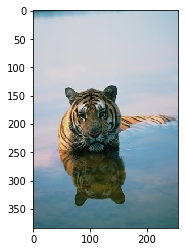

In [64]:
plt.imshow(Image.open('animal/tiger/108000.jpg'))

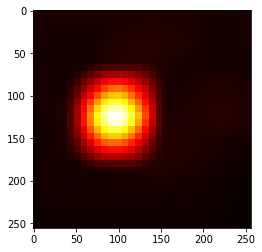

In [115]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

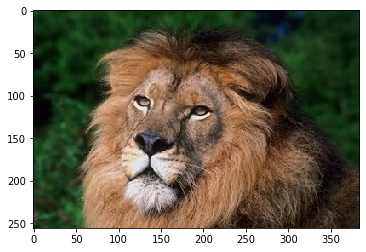

In [27]:
plt.imshow(Image.open('animal/lion/105000.jpg'))

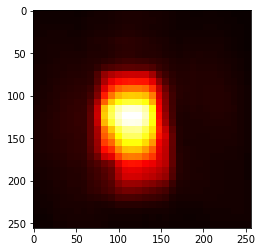

In [119]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

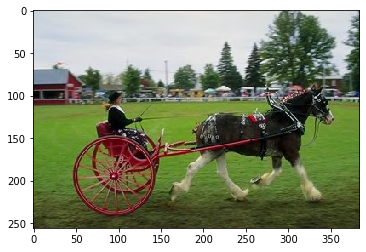

In [35]:
plt.imshow(Image.open('animal/horse/197006.jpg'))

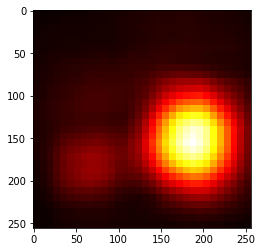

In [101]:
plt.imshow(heatmap,cmap='hot')

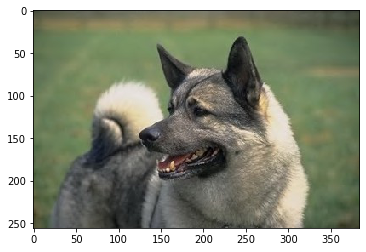

In [105]:
plt.imshow(Image.open('animal/dog/415002.jpg'))

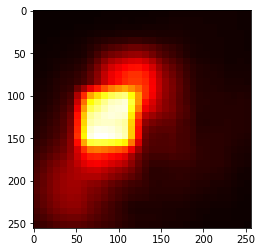

In [106]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

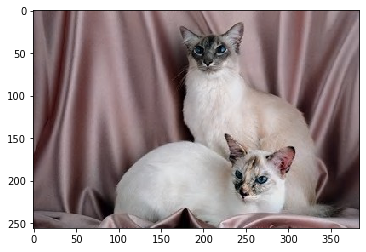

In [110]:
plt.imshow(Image.open('animal/cat/458008.jpg'))

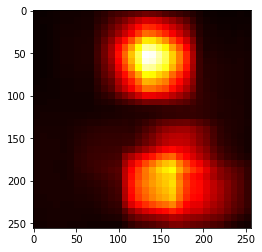

In [111]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

主に顔や鼻に注目していることがわかった。
差をどう取るかにも結果が左右されそうである。

In [68]:
h = 128
w = 128
mask = torch.zeros_like(img,dtype=torch.bool)
if h <0:
    upper = 0
else:
    upper = h

if 256<h+64:
    lower = 256
else:
    lower = h+64

if w<0:
    left = 0
else:
    left = w

if 256<w+64:
    right = 256
else:
    right = w+64

mask[0,0:3,left:right,upper:lower] = 1
masked_img = img.clone()
masked_img[mask]=0

with torch.no_grad():
    out=softmax(resnet50(masked_img.to("cuda:0"))).cpu().numpy()[0]

print("left=",left,", right=",right,", upper=",upper,", lower=",lower,", diff=",out[synset.index(top_name)])
heatmap[upper:lower, left:right] += abs(top_st - out[synset.index(top_name)])

left= 128 , right= 192 , upper= 128 , lower= 192 , diff= 0.17534998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


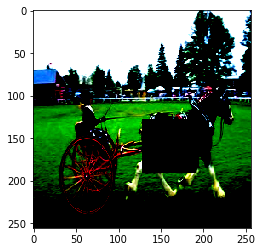

In [69]:
plt.imshow(  np.transpose(masked_img.numpy(),(0,2,3,1))[0]  )